# Bigram/Trigram with batchnorm

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
%matplotlib inline

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [3]:
url = "https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt"

# Local filename to save the downloaded file
filename = "names.txt"

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"File downloaded successfully as {filename}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully as names.txt


In [4]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
char = sorted(list(set(''.join(words)))) # set(''.join(words)) concatena e remove todas as repetições de caracteres
stoi = {s:i+1 for i, s in enumerate(char)} #Para cada letra cria seu índice
stoi['.'] = 0  # '.' será o indice 0. Indicador de inicio e fim de uma palavra
itos = {i:s for s, i in stoi.items()} #Para cada indice deixa mapeado a sua letra

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
vocab_size = len(stoi)
vocab_size

27

In [8]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(i.nelement() for i in parameters))
for p in parameters:
  p.requires_grad = True

12297


In [10]:
epochs=200000
batch_size = 32
lossi = []
for epoch in range(epochs):
  #MINIBATCH CONSTRUCT
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  ##FORWARD PASS
  emb = C[Xtr[ix]]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = (bngain * (hpreact - bnmeani) / bnstdi) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  #counts = logits.exp()
  #probs = counts / counts.sum(1, keepdim=True)
  #loss = -probs[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix])

  ### BACKWARD PASS
  for p in parameters:
    p.grad = None

  loss.backward()

  # lr = lrs[epoch]
  # lr_list.append(lr)
  # lre_list.append(lre[epoch])



  lr = 0.1 if epoch < 100000 else 0.01

  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10e3 == 0:
    print(f'epoch {epoch} - loss {loss.item():.4f}')
  lossi.append(loss.log10().item())

emb = C[Xtr]
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
#counts = logits.exp()
#probs = counts / counts.sum(1, keepdim=True)
#loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ytr)
print(f"Train Loss: {loss.item()}")

epoch 0 - loss 3.3147
epoch 10000 - loss 2.1984
epoch 20000 - loss 2.3375
epoch 30000 - loss 2.4359
epoch 40000 - loss 2.0119
epoch 50000 - loss 2.2595
epoch 60000 - loss 2.4775
epoch 70000 - loss 2.1020
epoch 80000 - loss 2.2788
epoch 90000 - loss 2.1862
epoch 100000 - loss 1.9474
epoch 110000 - loss 2.3010
epoch 120000 - loss 1.9837
epoch 130000 - loss 2.4523
epoch 140000 - loss 2.3839
epoch 150000 - loss 2.1987
epoch 160000 - loss 1.9733
epoch 170000 - loss 1.8668
epoch 180000 - loss 1.9973
epoch 190000 - loss 1.8347
Train Loss: 2.983690023422241


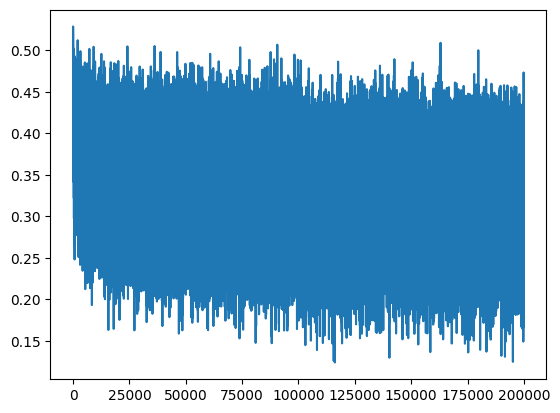

In [11]:
plt.plot(lossi)

In [12]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [13]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  hpreact = emb.view(emb.shape[0], -1) @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [14]:
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      hpreact = emb.view(emb.shape[0], -1) @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) / (bnstd) + bnbias
      h = torch.tanh(hpreact)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

wiler.
keyler.
alip.
chatou.
fadalexya.
kheili.
jaquaaisley.
ele.
bty.
xar.
sri.
koella.
josi.
itz.
cace.
kaxton.
adel.
bec.
yurletiah.
saidenorahvna.


In [27]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True) -> None:
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in **0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out = self.out + self.bias

    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]


with torch.no_grad():

  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1

  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

47551


In [28]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

  Xb, Yb = Xtr[ix], Ytr[ix]

  #forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)

  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb)

  #backward pass
  #for layer in layers:
  #  layer.out.retain_grad() # AFTER_DEBUG? would take out retain_grad

  for p in parameters:
    p.grad = None

  loss.backward()

  #update

  if i < 10000:
    lr = 0.1
  else:
    lr = 0.05
    
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
  #if i > 1000:
  #  break #AFTER_DEBUG? would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.3578
  20000/ 200000: 2.0901
  30000/ 200000: 1.9742
  40000/ 200000: 2.1737
  50000/ 200000: 2.2359
  60000/ 200000: 1.7860
  70000/ 200000: 2.2181
  80000/ 200000: 2.2405
  90000/ 200000: 1.8445
 100000/ 200000: 2.3285
 110000/ 200000: 2.2576
 120000/ 200000: 2.1487
 130000/ 200000: 1.8843
 140000/ 200000: 1.8225
 150000/ 200000: 1.9365
 160000/ 200000: 1.9812
 170000/ 200000: 1.9391
 180000/ 200000: 2.2473
 190000/ 200000: 2.0040


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

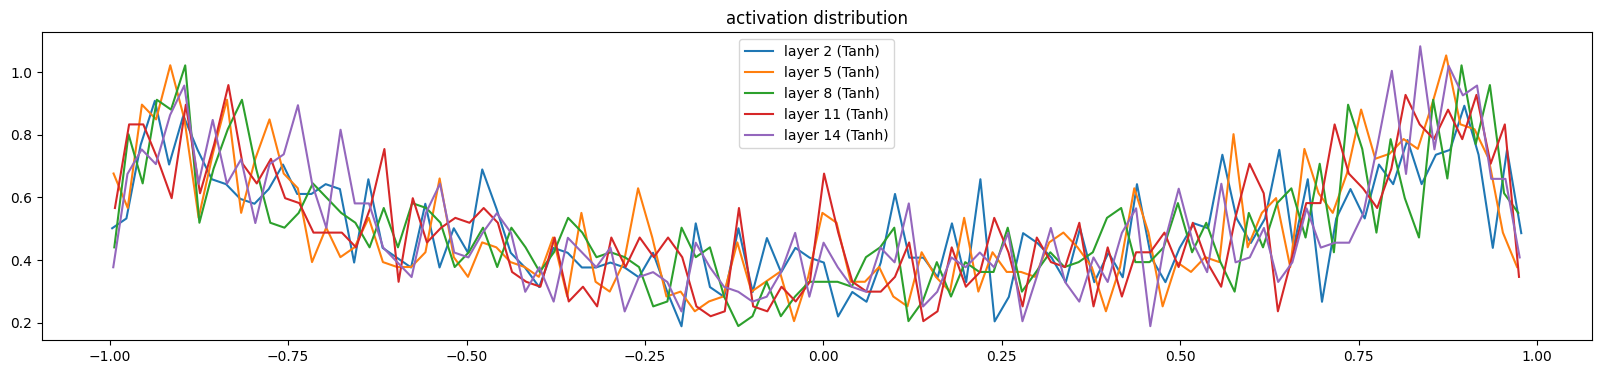

In [25]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.561966e-03
layer 5 (      Tanh): mean +0.000000, std 3.119518e-03
layer 8 (      Tanh): mean -0.000000, std 2.904400e-03
layer 11 (      Tanh): mean +0.000000, std 2.580220e-03
layer 14 (      Tanh): mean -0.000000, std 2.440870e-03


Text(0.5, 1.0, 'gradient distribution')

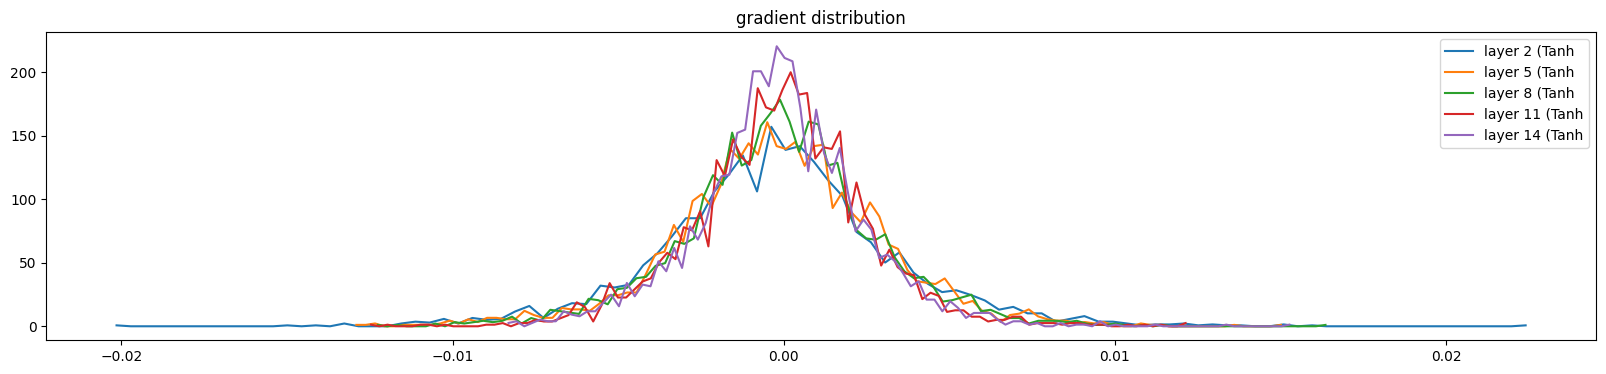

In [26]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.543199e-02 | grad:data ratio 1.519571e-02
weight  (30, 100) | mean -0.000026 | std 1.069252e-02 | grad:data ratio 3.170288e-02
weight (100, 100) | mean +0.000089 | std 7.819536e-03 | grad:data ratio 4.055852e-02
weight (100, 100) | mean +0.000031 | std 7.784847e-03 | grad:data ratio 4.077762e-02
weight (100, 100) | mean +0.000030 | std 7.713425e-03 | grad:data ratio 4.089162e-02
weight (100, 100) | mean +0.000032 | std 7.420515e-03 | grad:data ratio 3.986759e-02
weight  (100, 27) | mean +0.000203 | std 1.517644e-02 | grad:data ratio 6.705450e-02


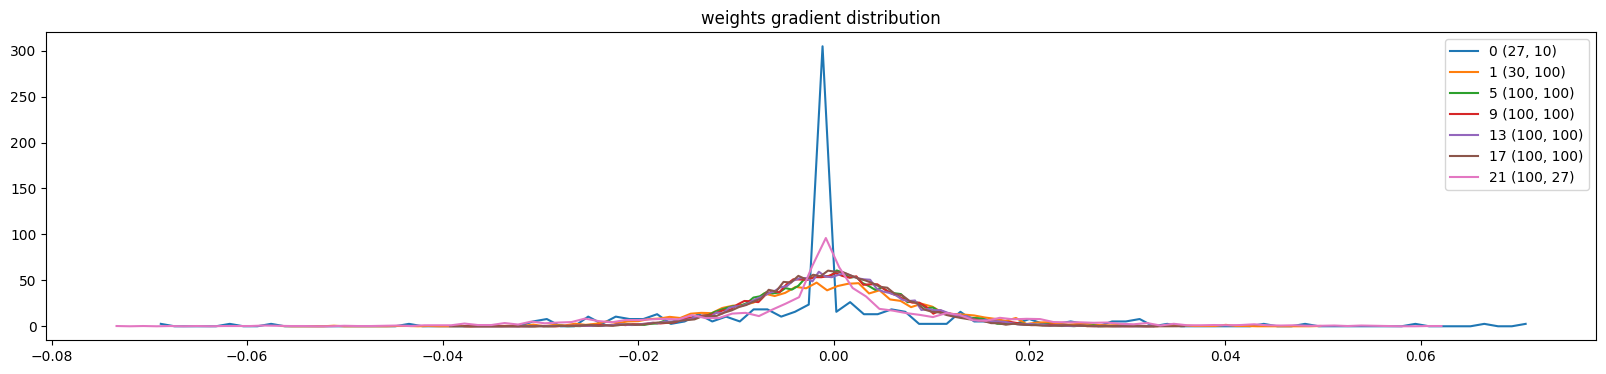

In [19]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

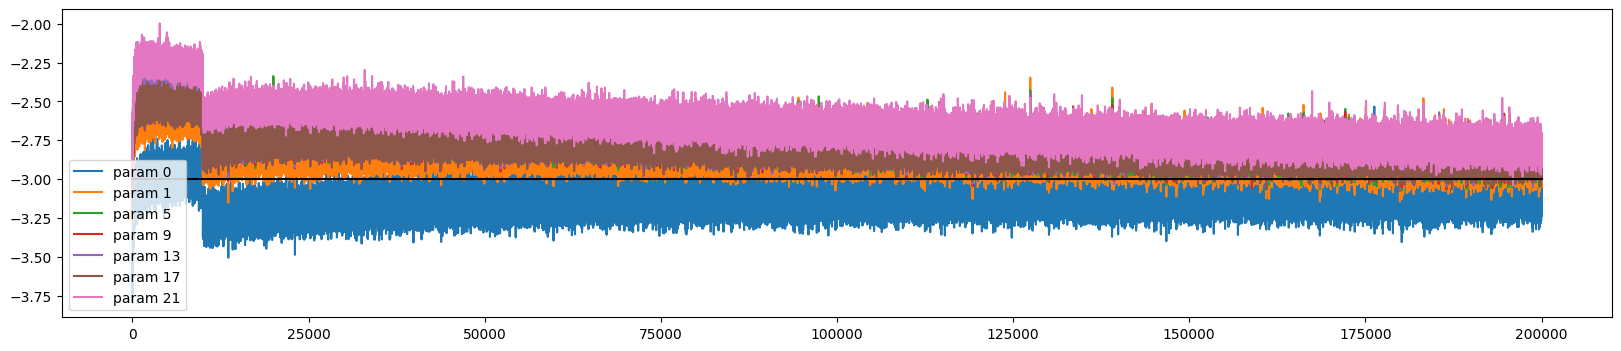

In [29]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [30]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0296030044555664
val 2.093651294708252


In [33]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amillivia.
jmri.
reet.
khalaysie.
rah.
braegerah.
jareen.
nellara.
chaiir.
kaleigh.
ham.
joce.
quinthorocken.
jadiquinte.
madiaryn.
kai.
evailua.
med.
edi.
